In [1]:
import pathlib
import numpy as np
import scipy.constants
from fytok.Tokamak import Tokamak
from fytok.modules.Equilibrium import Equilibrium
from fytok.utils.logger import logger
from spdm.view.View import display
from spdm.data.File import File
from spdm.data.Path import Path
from spdm.data.Entry import Entry
from spdm.view import View as sp_view

WORKSPACE = "/home/salmon/workspace"  # "/ssd01/salmon_work/workspace/"
output_path = pathlib.Path(f"{WORKSPACE}/output/")

2024-01-08 10:48:05,145 [    spdm]     INFO: 
###################################################################################################

    ______      _____     _
   / ____/_  __|_   _|__ | | __
  / /_  / / / /  | |/ _ \| |/ /
 / __/ / /_/ /   | | (_) |   <
/_/    \__, /    |_|\___/|_|\_\
      /____/

 Copyright (c) 2021-present Zhi YU (Institute of Plasma Physics Chinese Academy of Sciences)
            
 url: https://gitee.com/openfusion/fytok_tutorial 
      https://github.com/fusion-yun/fytok_tutorial

 version = alpha  (spdm=beta extension=0.2.2.dev19+g14adade.d20231205, imas_version=v3_38_1_dirty)

 Run by salmon at 2024-01-08T10:48:04.973875.
 Job ID: fytok_salmon_surface_19258

###################################################################################################



In [2]:
input_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")
# equilibrium = Equilibrium(f"file+GEQdsk://{WORKSPACE}/gacode/neo/tools/input/profile_data/g141459.03890#equilibrium")
tok = Tokamak(
    # "file+geqdsk:///home/salmon/workspace/fytok_data/data/g070754.05000",
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="east",
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.01, 0.999, 128)}}},
)

2024-01-08 10:48:05,401 [    spdm]     INFO: Load module spdm.plugins.data.plugin_xml
2024-01-08 10:48:05,695 [    spdm]     INFO: Load module spdm.plugins.data.plugin_iterprofiles
2024-01-08 10:48:05,783 [    spdm]     INFO: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
eq = tok.equilibrium.time_slice.current
coord = eq.coordinate_system


2024-01-08 10:48:05,924 [    spdm]     INFO: Load module fytok.plugins.equilibrium.fy_eq
2024-01-08 10:48:05,928 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-01-08 10:48:05,940 [    spdm]     INFO: Load module spdm.mesh.mesh_rectangular
2024-01-08 10:48:05,980 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:131:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0


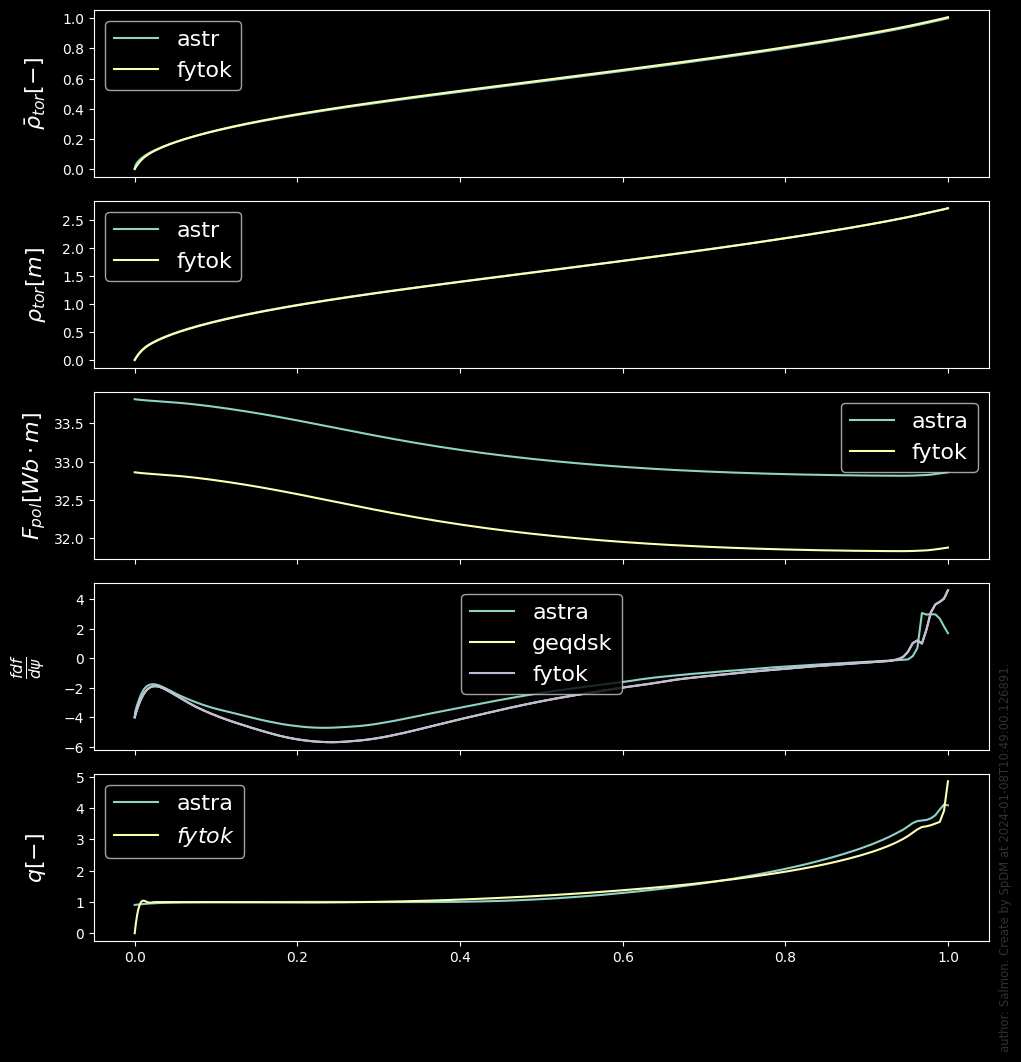

In [6]:
from spdm.data.Function import Function

eqdsk_file = File(f"file+geqdsk://{next(input_path.glob('**/g*.txt')).absolute().as_posix()}").entry
psi_axis = eqdsk_file.get("equilibrium/time_slice/0/global_quantities/psi_axis")
psi_boundary = eqdsk_file.get("equilibrium/time_slice/0/global_quantities/psi_boundary")
bs_eq_psi = eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/psi")
bs_eq_psi_norm = (bs_eq_psi - psi_axis) / (psi_boundary - psi_axis)
bs_eq_fpol = Function(bs_eq_psi_norm, eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/f"))


core_profiles_1d = tok.core_profiles.time_slice.current.profiles_1d

eq_1d = tok.equilibrium.time_slice.current.profiles_1d

fig = sp_view.plot(
    core_profiles_1d.grid.psi_norm,
    (
        [
            (core_profiles_1d.grid.rho_tor_norm, "astr"),
            (Function(eq_1d.grid.psi_norm, eq_1d.grid.rho_tor_norm), "fytok"),
        ],
        {"y_label": r"$\bar{\rho}_{tor}[-]$"},
    ),
    (
        [
            (core_profiles_1d.rho_tor(eq_1d.rho_tor_norm), "astr"),
            (eq_1d.rho_tor, "fytok"),
        ],
        {"y_label": r"$\rho_{tor}[m]$"},
    ),
    (
        [
            (-bs_eq_fpol, "astra"),
            (tok.equilibrium.time_slice.current.profiles_1d.f, r"fytok"),
        ],
        {"y_label": r"$F_{pol} [Wb\cdot m]$"},
    ),
    (
        [
            (-core_profiles_1d.ffprime(core_profiles_1d.grid.rho_tor_norm) * 2.0 * scipy.constants.pi, "astra"),
            (Function(bs_eq_psi_norm, eqdsk_file.get("equilibrium/time_slice/0/profiles_1d/f_df_dpsi")), "geqdsk"),
            (eq_1d.f_df_dpsi, r"fytok"),
        ],
        {"y_label": r"$\frac{f df}{d\psi} $"},
    ),
    (
        [
            (core_profiles_1d.q, r"astra"),
            (eq_1d.q, {"label": r"$fytok$"}),
        ],
        {"y_label": r"$q [-]$"},
    ),
    # (
    #     [
    #         (
    #             function_like(4 * (scipy.constants.pi**2) * R0 * profiles["rho"].values, bs_psi),
    #             {"label": r"$4\pi^2 R_0 \rho$", **bs_line_style},
    #         ),
    #         (
    #             eq_profiles_1d.dvolume_drho_tor,
    #             {
    #                 "label": r"$dV/d\rho_{tor}$",
    #             },
    #         ),
    #     ],
    #     {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"},
    # ),
)

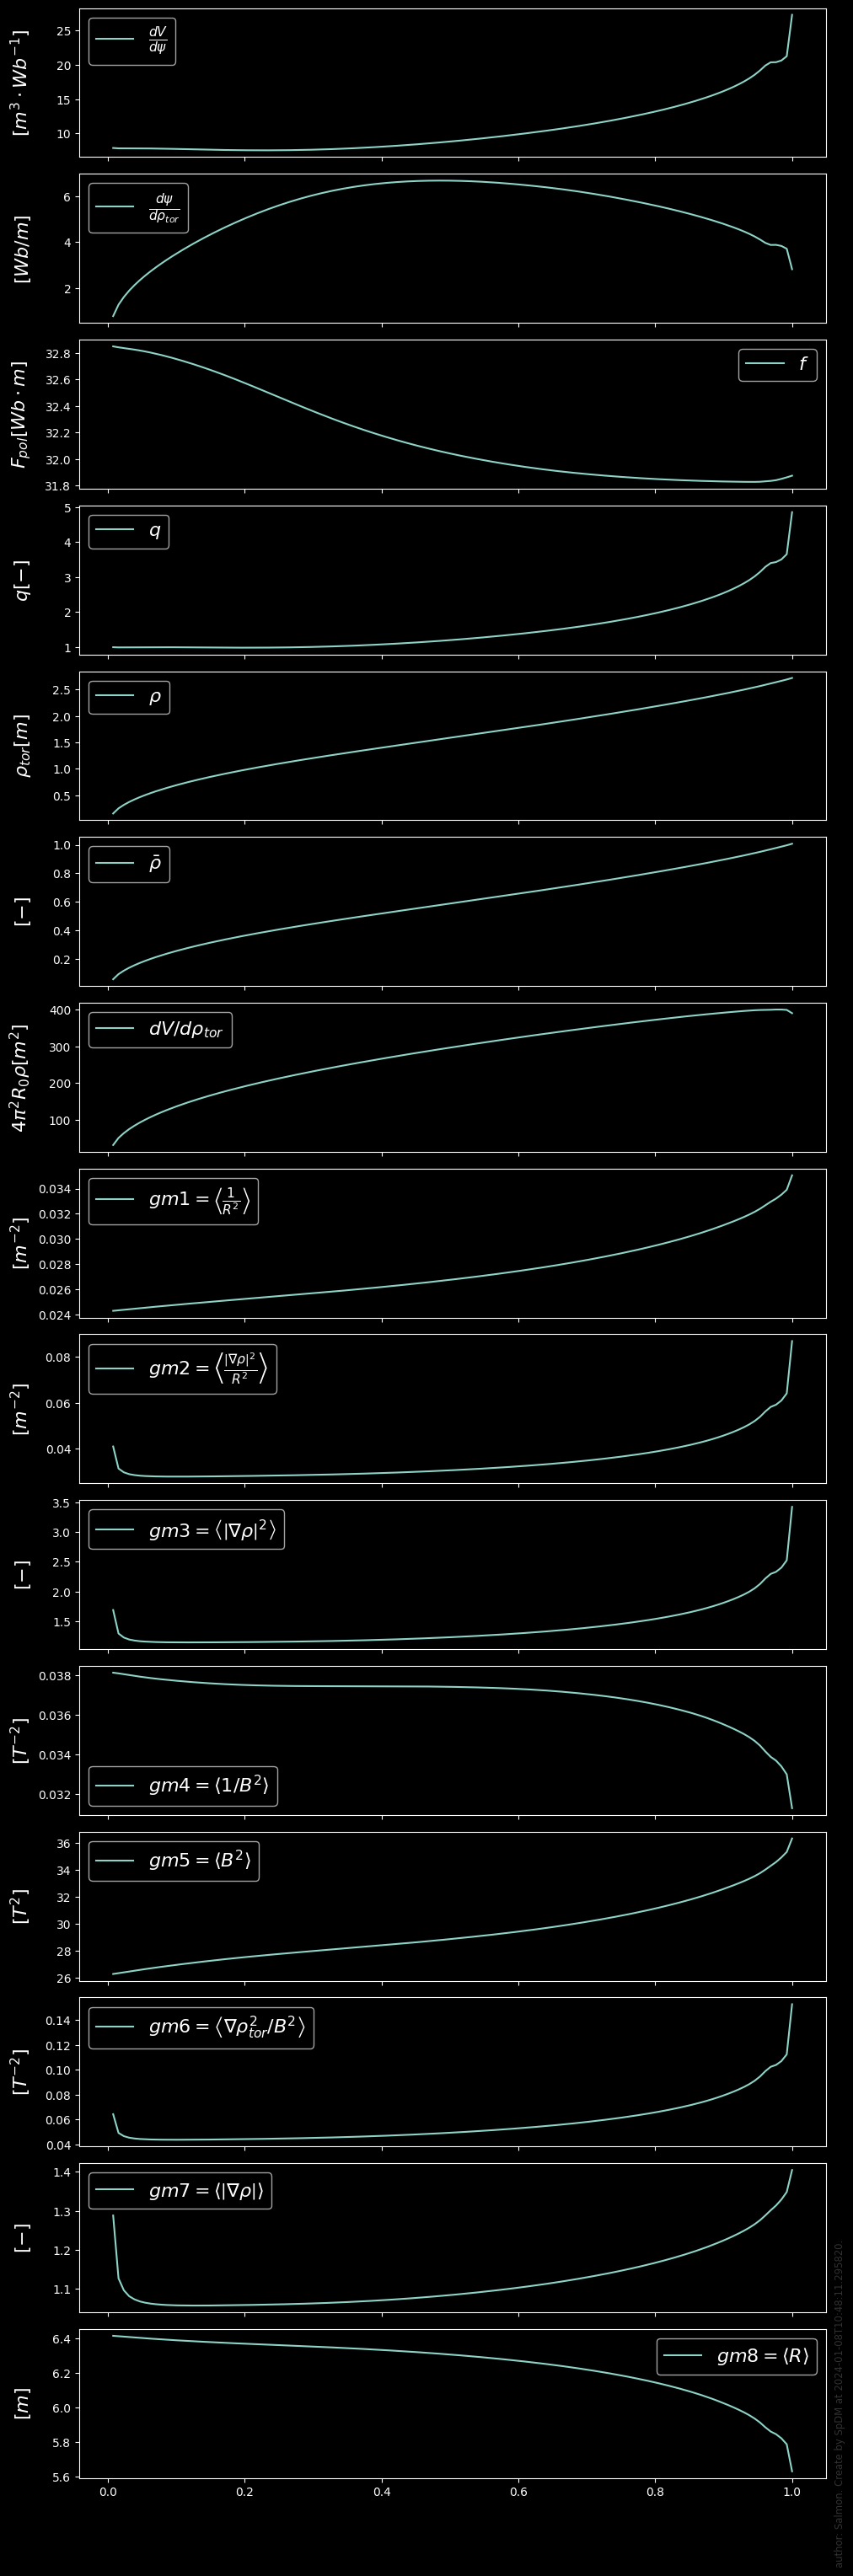

In [5]:
eq_profiles_1d = tok.equilibrium.time_slice.current.profiles_1d
fig = sp_view.plot(  # plot tokamak geometric profile
    eq_profiles_1d.grid.psi_norm[1:],
    (eq_profiles_1d.dvolume_dpsi, r"$\frac{dV}{d\psi}$"),
    (eq_profiles_1d.dpsi_drho_tor, r"$\frac{d\psi}{d\rho_{tor}}$"),
    (eq_profiles_1d.f, {"y_label": r"$F_{pol} [Wb\cdot m]$"}),
    (eq_profiles_1d.q, {"y_label": r"$q [-]$"}),
    ((eq_profiles_1d.rho_tor, r"$\rho$"), {"y_label": r"$\rho_{tor}[m]$"}),
    ((eq_profiles_1d.rho_tor_norm, r"$\bar{\rho}$"), {"y_label": r"[-]"}),
    ((eq_profiles_1d.dvolume_drho_tor, r"$dV/d\rho_{tor}$"), {"y_label": r"$4\pi ^ 2 R_0 \rho[m ^ 2]$"}),
    (eq_profiles_1d.gm1, r"$gm1=\left<\frac{1}{R^2}\right>$"),
    (eq_profiles_1d.gm2, r"$gm2=\left<\frac{\left|\nabla \rho\right|^2}{R^2}\right>$"),
    (eq_profiles_1d.gm3, r"$gm3=\left<\left|\nabla \rho\right|^2\right>$"),
    (eq_profiles_1d.gm4, r"$gm4=\left<1/B^2\right>$"),
    (eq_profiles_1d.gm5, r"$gm5=\left<B^2\right>$"),
    (eq_profiles_1d.gm6, r"$gm6=\left<\nabla \rho_{tor}^2/ B^2 \right>$"),
    (eq_profiles_1d.gm7, r"$gm7=\left<\left|\nabla \rho\right|\right>$"),
    (eq_profiles_1d.gm8, r"$gm8=\left<R\right>$"),
)